In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from matplotlib import pyplot as plt
import seaborn as sn
import numpy as np
from sklearn import metrics

###Dataset and analysis

In [ ]:
#The labelled portion of our dataset has labels 0, 1, 2 for the three levels of empathy (no, weak, strong)

data = pd.read_csv('drive/MyDrive/empathy_labelled_ds.csv')#put data in Drive root folder or change path
len(data)

1100

In [ ]:
data.head()

,response,annotator1_score,annotator2_score,annotator3_score,empathy_score
0,When you've selected the protocol you want to ...,1,2,2,2
1,Did something happen to you?,0,0,1,0
2,"Thank you for taking part, I really appreciate...",2,1,2,2
3,I am grateful for your participation. I hope t...,1,2,2,2
4,"Thank you for being so open, I'm trying to det...",2,2,2,2


In [ ]:
#We consider the overall empathy_score (derived from the individual scores given by the 3 annotators).
#The classes in this dataset are approximately balanced
data.groupby('empathy_score').size()

empathy_score
0    331
1    388
2    381
dtype: int64

In [ ]:
#we drop the annotator columns before saving splits
data = data.drop(['annotator1_score', 'annotator2_score', 'annotator3_score'], axis=1)

#We replace the numerical labels with more meaningful string labels (useful to later use t5)
data["empathy_score"].replace({0: "no", 1: "weak", 2: "strong"}, inplace=True)

In [ ]:
#sanity check
data.head()

,response,empathy_score
0,When you've selected the protocol you want to ...,strong
1,Did something happen to you?,no
2,"Thank you for taking part, I really appreciate...",strong
3,I am grateful for your participation. I hope t...,strong
4,"Thank you for being so open, I'm trying to det...",strong


In [ ]:
#generate the text files for your train, val, and test datasets (we use an 85:5:10 split)

train_path = "drive/MyDrive/empathy_classifier_data/my_train.txt"
test_path = "drive/MyDrive/empathy_classifier_data/my_test.txt"
val_path = "drive/MyDrive/empathy_classifier_data/my_val.txt"


from sklearn.model_selection import train_test_split
import numpy as np

# Creating training and validation sets using an 85-15 split
input_train, input_val, target_train, target_val = train_test_split(data.response.to_numpy(), 
                                                                    data.empathy_score.to_numpy(), 
                                                                    test_size=0.15)

# Split the validataion further to obtain a holdout dataset (for testing) -- split 67:33
input_val, input_test, target_val, target_test = train_test_split(input_val, target_val, test_size=0.67)


## create a dataframe for each dataset
train_dataset = pd.DataFrame(data={"text": input_train, "class": target_train})
val_dataset = pd.DataFrame(data={"text": input_val, "class": target_val})
test_dataset = pd.DataFrame(data={"text": input_test, "class": target_test})
final_dataset = {"train": train_dataset, "val": val_dataset , "test": test_dataset }

#and write them to file
train_dataset.to_csv(train_path, sep=";",header=False, index=False)
val_dataset.to_csv(val_path, sep=";",header=False, index=False)
test_dataset.to_csv(test_path, sep=";",header=False, index=False)

In [ ]:
#we will use the concatenated train and validation test to fit our logistic regression function
train_val = pd.concat([train_dataset, val_dataset])

In [ ]:
train_val.head()

,text,class
0,Are you always trying blame yourself for negat...,no
1,I'm going to ask you now about some other nega...,weak
2,Have you recently revisited the trauma of this...,weak
3,"Deep down, would you say that you feel good wh...",strong
4,"I see, thanks. And was this event, or events, ...",no


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


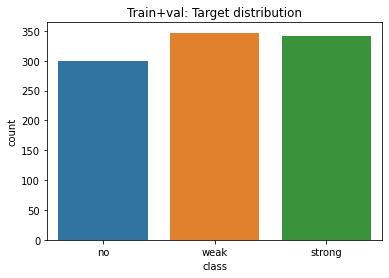

In [ ]:
#visualise label distribution
sn.countplot(train_val['class']);
plt.title('Train+val: Target distribution');

In [ ]:
text_transformer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), lowercase=True, max_features=150000)

In [ ]:
X_train_text = text_transformer.fit_transform(train_val['text'])
X_test_text = text_transformer.transform(test_dataset['text'])

In [ ]:
print(X_train_text.shape, 
      X_test_text.shape)

(989, 4244) (111, 4244)


In [ ]:
logit = LogisticRegression(C=5e1, solver='lbfgs', multi_class='multinomial', random_state=17, n_jobs=4)

In [ ]:
logit.fit(X_train_text, train_val['class'])

LogisticRegression(C=50.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=4, penalty='l2',
                   random_state=17, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
test_preds = logit.predict(X_test_text)

In [ ]:
y_pred = pd.DataFrame(test_preds, columns=['class'])
y_pred.head()

,class
0,weak
1,weak
2,strong
3,weak
4,weak


In [ ]:
#check accuracy, we get ~60% on train+val set
outputs = y_pred['class'].to_numpy().tolist()
targets = test_dataset['class'].to_numpy().tolist()

metrics.accuracy_score(targets, outputs).round(4)

0.6577

In [ ]:
#check all metrics
print(metrics.classification_report(targets, outputs, digits=4))

              precision    recall  f1-score   support

          no     0.6176    0.6774    0.6462        31
      strong     0.7368    0.7179    0.7273        39
        weak     0.6154    0.5854    0.6000        41

    accuracy                         0.6577       111
   macro avg     0.6566    0.6602    0.6578       111
weighted avg     0.6587    0.6577    0.6576       111



In [ ]:
cm = metrics.confusion_matrix(targets, outputs)

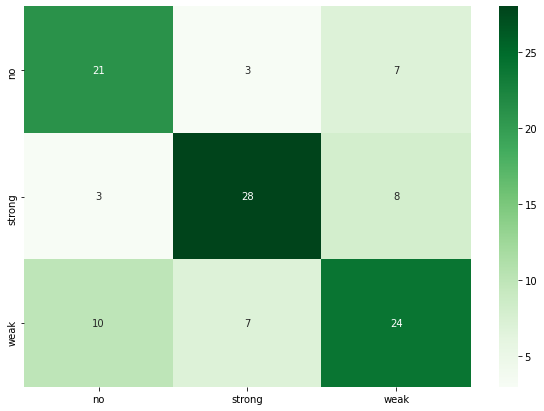

In [ ]:
df_cm = pd.DataFrame(cm, index = ["no", "strong", "weak"], columns = ["no", "strong", "weak"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Greens', fmt='g')